# Introduction
In this competition, we have to develop accurate models of metered building energy usage in the following areas: chilled water, electric, hot water, and steam meters. The data comes from over 1,000 buildings over a three-year timeframe. With better estimates of these energy-saving investments, large scale investors and financial institutions will be more inclined to invest in this area to enable progress in building efficiencies.

**About the Host**
![](https://www.googleapis.com/download/storage/v1/b/kaggle-user-content/o/inbox%2F1095143%2Ff9ab8963dea5e7c1716f47310daa96ab%2FASHRAE_Logo_25.jpg?generation=1570808142334850&alt=media)

Founded in 1894, ASHRAE serves to advance the arts and sciences of heating, ventilation, air conditioning refrigeration and their allied fields. ASHRAE members represent building system design and industrial process professionals around the world. With over 54,000 members serving in 132 countries, ASHRAE supports research, standards writing, publishing and continuing education - shaping tomorrow’s built environment today.

# 1. Importing Packages and Collecting Data

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import os, gc
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import holidays
sns.set_style("whitegrid")          
%matplotlib inline

In [2]:
# config
ROOT_PATH = Path('.').resolve().parent
DATA_PATH = ROOT_PATH / 'data'

In [3]:
train = pd.read_pickle(DATA_PATH / 'train.pkl')
test  = pd.read_pickle(DATA_PATH / 'test.pkl')
weather_train = pd.read_pickle(DATA_PATH / 'weather_train.pkl')
weather_test = pd.read_pickle(DATA_PATH / 'weather_test.pkl')
weather = weather_train.append(weather_test)
meta = pd.read_pickle(DATA_PATH / 'building_metadata.pkl')
del weather_train, weather_test
gc.collect()

15

In [4]:
locate = {
        0: {'country': 'US', 'offset': -4},
        1: {'country': 'UK', 'offset': 0},
        2: {'country': 'US', 'offset': -7},
        3: {'country': 'US', 'offset': -4},
        4: {'country': 'US', 'offset': -7},
        5: {'country': 'UK', 'offset': 0},
        6: {'country': 'US', 'offset': -4},
        7: {'country': 'CAN', 'offset': -4},
        8: {'country': 'US', 'offset': -4},
        9: {'country': 'US', 'offset': -5},
        10: {'country': 'US', 'offset': -7},
        11: {'country': 'CAN', 'offset': -4},
        12: {'country': 'IRL', 'offset': 0},
        13: {'country': 'US', 'offset': -5},
        14: {'country': 'US', 'offset': -4},
        15: {'country': 'US', 'offset': -4},
    }


def weather_timestamp_aligned(df):
    site_offset = pd.DataFrame(locate).T.offset.to_dict()
    site_offset = df.site_id.map(site_offset)
    df['timestamp'] = df.timestamp + pd.to_timedelta(site_offset, unit='H')
    return df


weather = weather_timestamp_aligned(weather)

In [6]:
train = train.merge(meta, on = 'building_id', how = 'left')
test = test.merge(meta, on = 'building_id', how = 'left')
train = train.merge(weather, on = ['site_id', 'timestamp'], how = 'left')
test = test.merge(weather, on = ['site_id', 'timestamp'], how = 'left')

**Well! we have lot of missing value in the both train and test data.**

In [7]:
train.isnull().sum() / train.shape[0]

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.599900
floor_count           0.826528
air_temperature       0.004778
cloud_coverage        0.436603
dew_temperature       0.004950
precip_depth_1_hr     0.185380
sea_level_pressure    0.060852
wind_direction        0.071679
wind_speed            0.007104
dtype: float64

In [8]:
test.isnull().sum() / test.shape[0]

row_id                0.000000
building_id           0.000000
meter                 0.000000
timestamp             0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.589916
floor_count           0.826050
air_temperature       0.005552
cloud_coverage        0.468762
dew_temperature       0.006485
precip_depth_1_hr     0.187303
sea_level_pressure    0.060589
wind_direction        0.071665
wind_speed            0.007475
dtype: float64

# Feature Engineering - Part I
The code block below will be expanded on over time as I come up with some new features.

Engineered features include:

* Month of the year
* Day of the week of the timestamp
* Hour of the day

In [9]:
train["hour"] = np.uint8(train["timestamp"].dt.hour)
train["day"] = np.uint8(train["timestamp"].dt.day)
train["weekday_name"] = train["timestamp"].dt.weekday_name 
train["weekday"] = np.uint8(train["timestamp"].dt.weekday)
train["month"] = np.uint8(train["timestamp"].dt.month)

# test["hour"] = np.uint8(test["timestamp"].dt.hour)
# test["day"] = np.uint8(test["timestamp"].dt.day)
# test["weekday"] = np.uint8(test["timestamp"].dt.weekday)
# test["month"] = np.uint8(test["timestamp"].dt.month)

def add_holiday(x):
    time_range = pd.date_range(start='2015-12-31', end='2019-01-01', freq='h')
    country_holidays = {'UK': holidays.UK(), 'US': holidays.US(), 'IRL': holidays.Ireland(), 'CAN': holidays.Canada()}

    holiday_mapping = pd.DataFrame()
    for site in range(16):
        holiday_mapping_i = pd.DataFrame({'site_id': site, 'timestamp': time_range})
        holiday_mapping_i['h0'] = holiday_mapping_i['timestamp'].apply(
            lambda x: x in country_holidays[locate[site]['country']]).astype(int)
        holiday_mapping = pd.concat([holiday_mapping, holiday_mapping_i], axis=0)

    x = pd.merge(x, holiday_mapping, on=['site_id', 'timestamp'], how='left')
    return x

train = add_holiday(train)
# test = add_holiday(test)

In [10]:
train['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)
# test['meter'].replace({0:"Electricity",1:"ChilledWater",2:"Steam",3:"HotWater"},inplace=True)

# 3. Exploratory Data Analysis (EDA)

## 3.1 Target Variable Analysis:- meter_reading

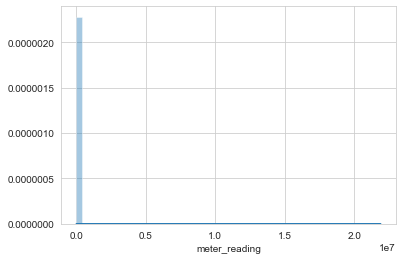

In [12]:
sns.distplot(train.meter_reading)

**It's seems that meter reading variable is heavily positive skewed with outliears.
Let's fixed that.**


In [14]:
'''Summary of meter reading'''
train['meter_reading'].describe()

count    2.021610e+07
mean     1.988706e+03
std      1.532159e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64

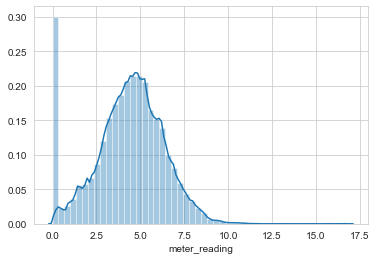

In [15]:

train['meter_reading'] = np.log1p(train['meter_reading'])
sns.distplot(train.meter_reading)

In [149]:
stat = train.groupby(['building_id', 'meter']).meter_reading.median().reset_index()

In [152]:
stat[stat.meter == 'Electricity'].sort_values('meter_reading')

,building_id,meter,meter_reading
1068,815,Electricity,0.000000
1043,799,Electricity,0.000000
1052,802,Electricity,0.000000
1070,817,Electricity,0.000000
1106,853,Electricity,0.000000
...,...,...,...
1037,797,Electricity,7.884644
1570,1088,Electricity,7.982177
1028,794,Electricity,8.272388
1049,801,Electricity,8.326476


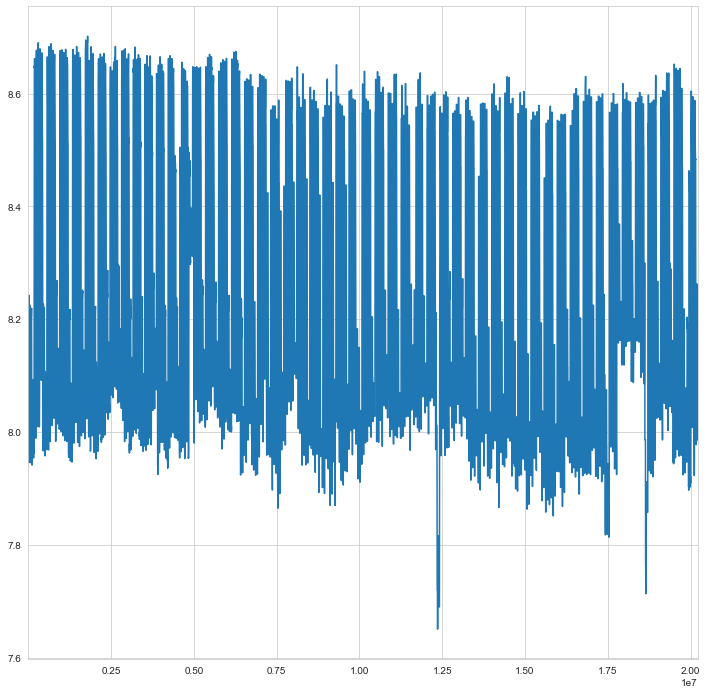

In [158]:
train[(train.building_id == 794) & (train.meter == 'Electricity')].meter_reading.plot()

## 3.2 Meter Reading and Meter Type
There are four different meter types and are displayed below:

* 0: electricity
* 1: chilledwater
* 2: steam
* 3: hotwater

We can see that the steam meter type tends to have higher meter readings, while electricity tends to have the lowest energy readings.

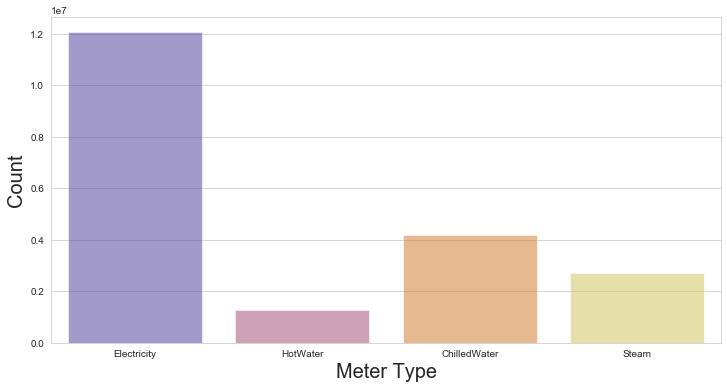

In [17]:
plt.rcParams['figure.figsize'] = (12, 6)
ax = sns.countplot(data = train, x ='meter', palette = 'CMRmap', alpha = 0.5)
ax.set_ylabel('Count', fontsize = 20)
ax.set_xlabel('Meter Type', fontsize = 20)
plt.show()

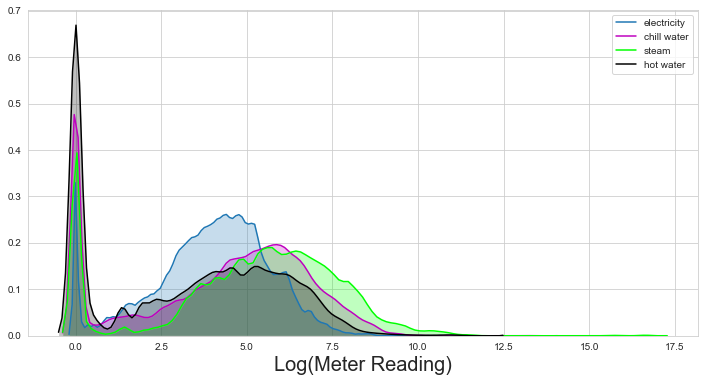

In [19]:
plt.rcParams['figure.figsize'] = (12, 6)

temp_df = train[train["meter"]=="Electricity"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="electricity")
temp_df = train[train["meter"]=="ChilledWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="chill water", color = 'm')
temp_df = train[train["meter"]=="Steam"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="steam", color = 'lime')
temp_df = train[train["meter"]=="HotWater"]
ax = sns.kdeplot(temp_df['meter_reading'], shade = True, label="hot water", color = 'k')
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
plt.show()

## 3.3 Weekday and Meter Reading

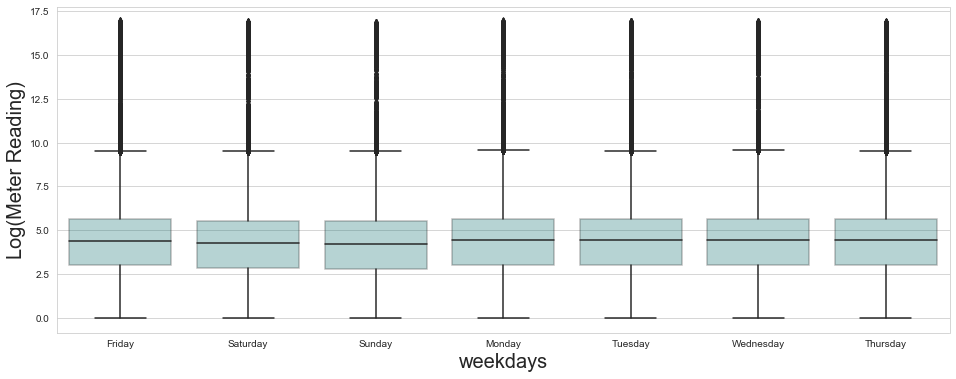

In [21]:

plt.rcParams['figure.figsize'] = (16, 6)
ax = sns.boxplot(data = train, x ='weekday_name', y = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_ylabel('Log(Meter Reading)', fontsize = 20)
ax.set_xlabel('weekdays', fontsize = 20)
plt.show()

## 3.4 Time of Day and Meter Reading

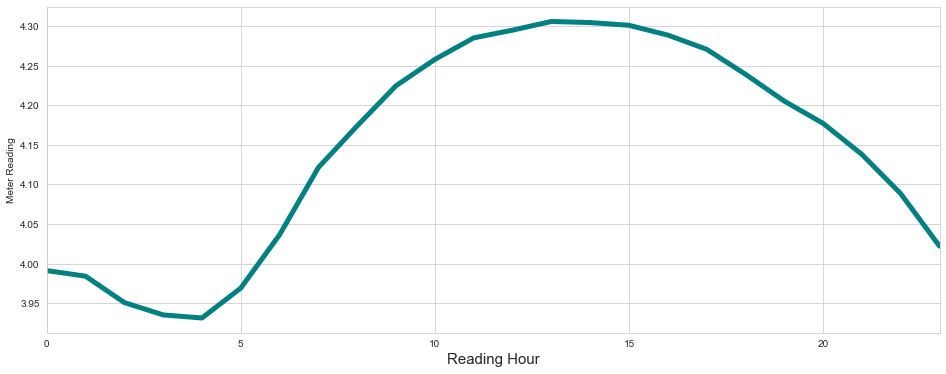

In [27]:
# bold('**READINGS HIGHEST DURING THE MIDDLE OF THE DAY**')
plt.rcParams['figure.figsize'] = (16,6)
temp_df = train.groupby('hour').meter_reading.mean()
temp_df.plot(linewidth = 5, color = 'teal')
plt.xlabel('Reading Hour', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

Reading are significantly higher during traditional work hours and this is to be expected. Time of day appears like it will be a significant predictor in any subsequent model for this competition.

# 3.5 Primary Use and Meter Reading

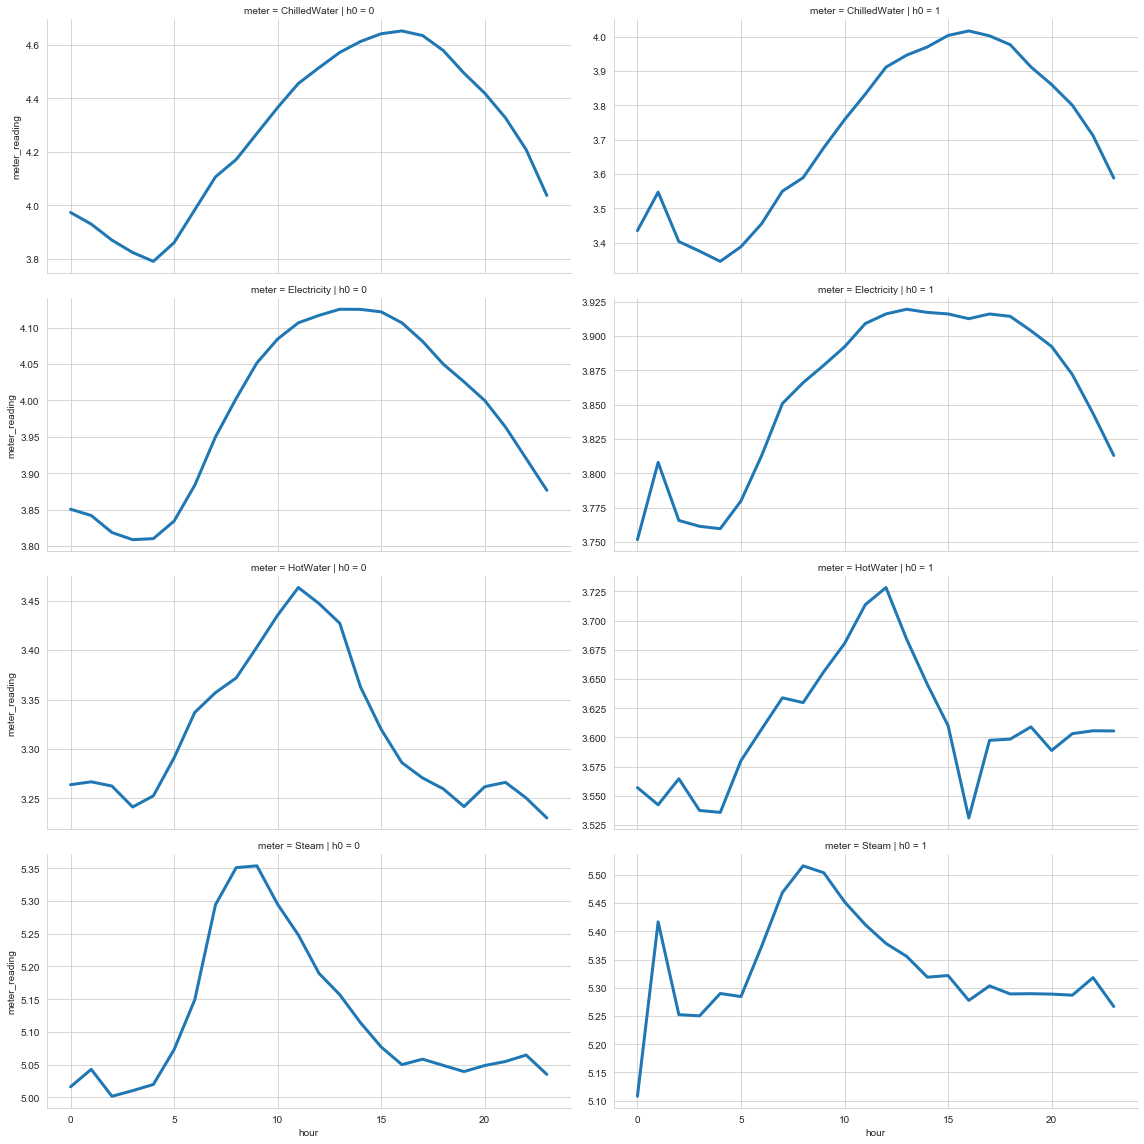

In [42]:
temp_df = train.groupby(['h0', 'hour', 'meter']).meter_reading.mean().reset_index()
ax = sns.FacetGrid(temp_df, col="h0", row='meter', height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'hour', 'meter_reading', linewidth = 3)
# plt.subplots_adjust(hspace=0.45)
plt.show()

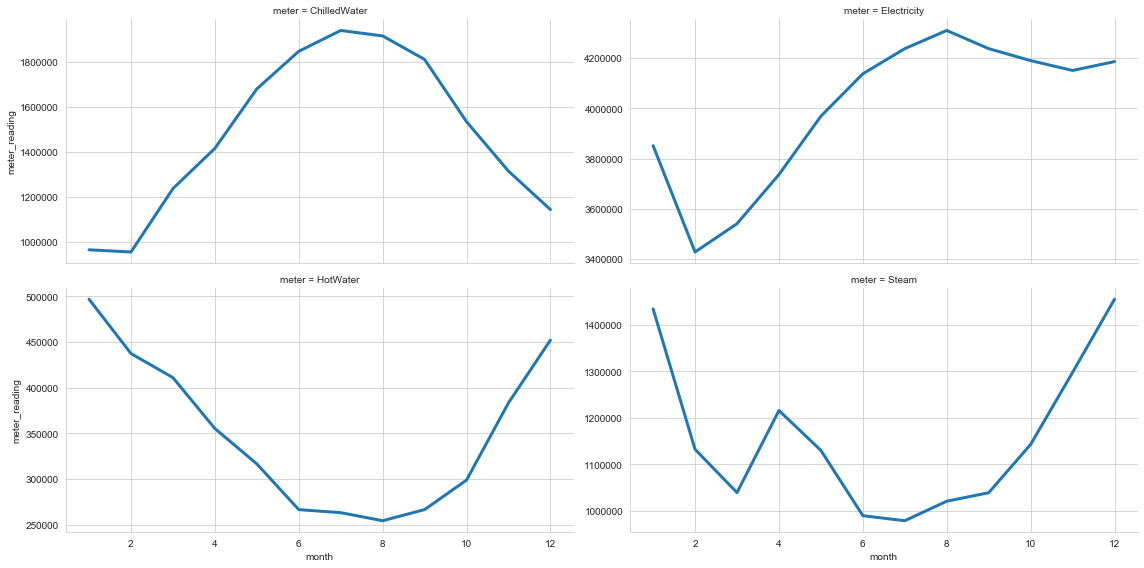

In [36]:
temp_df = train.groupby(['month', 'meter']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="meter", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', linewidth = 3)
# plt.subplots_adjust(hspace=0.45)
plt.show()

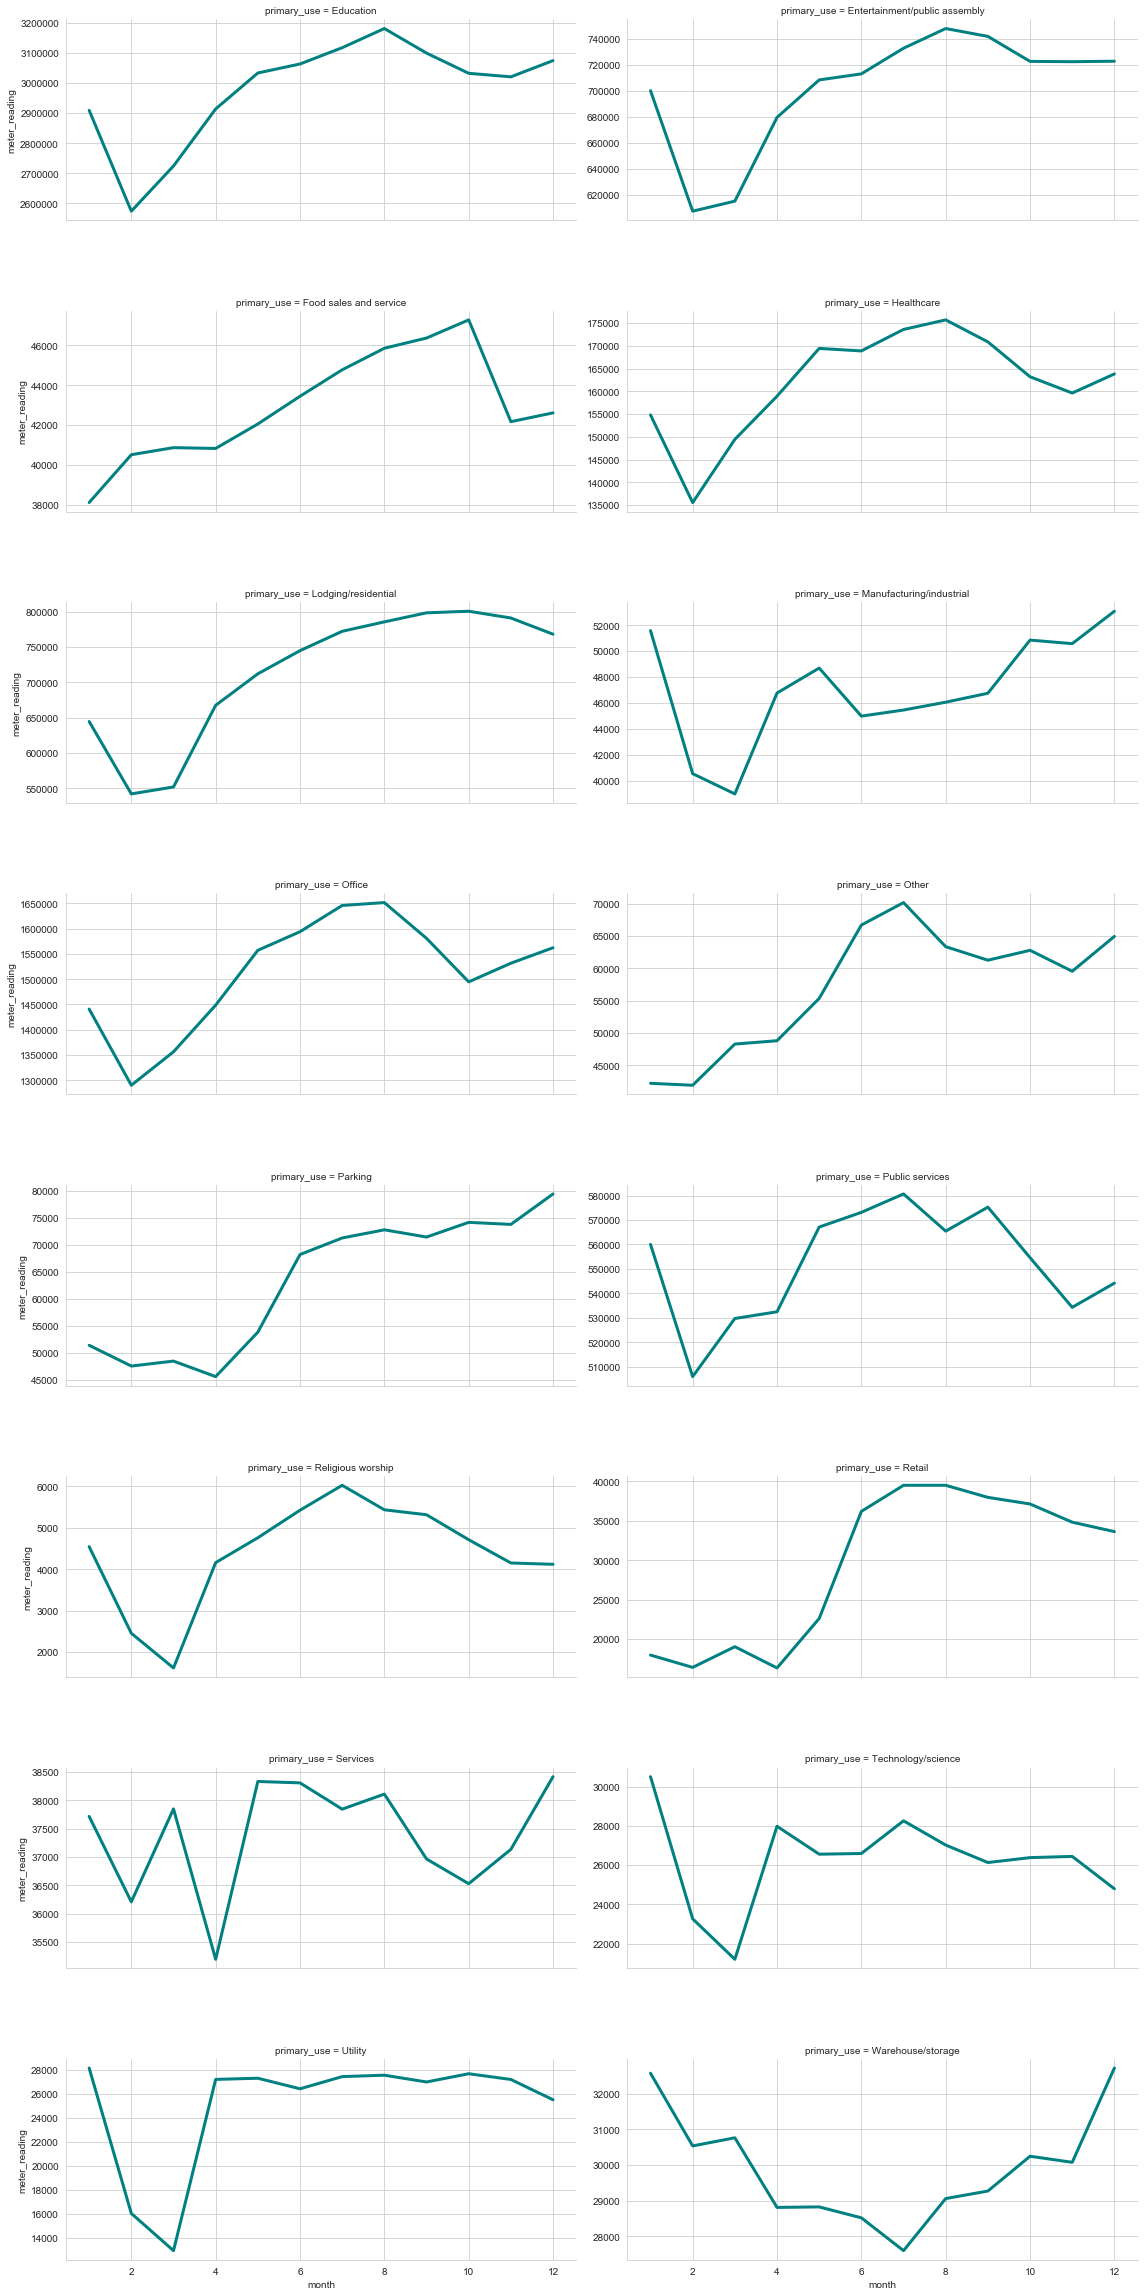

In [28]:
# bold('**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**')
temp_df = train.groupby(['month', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'month', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

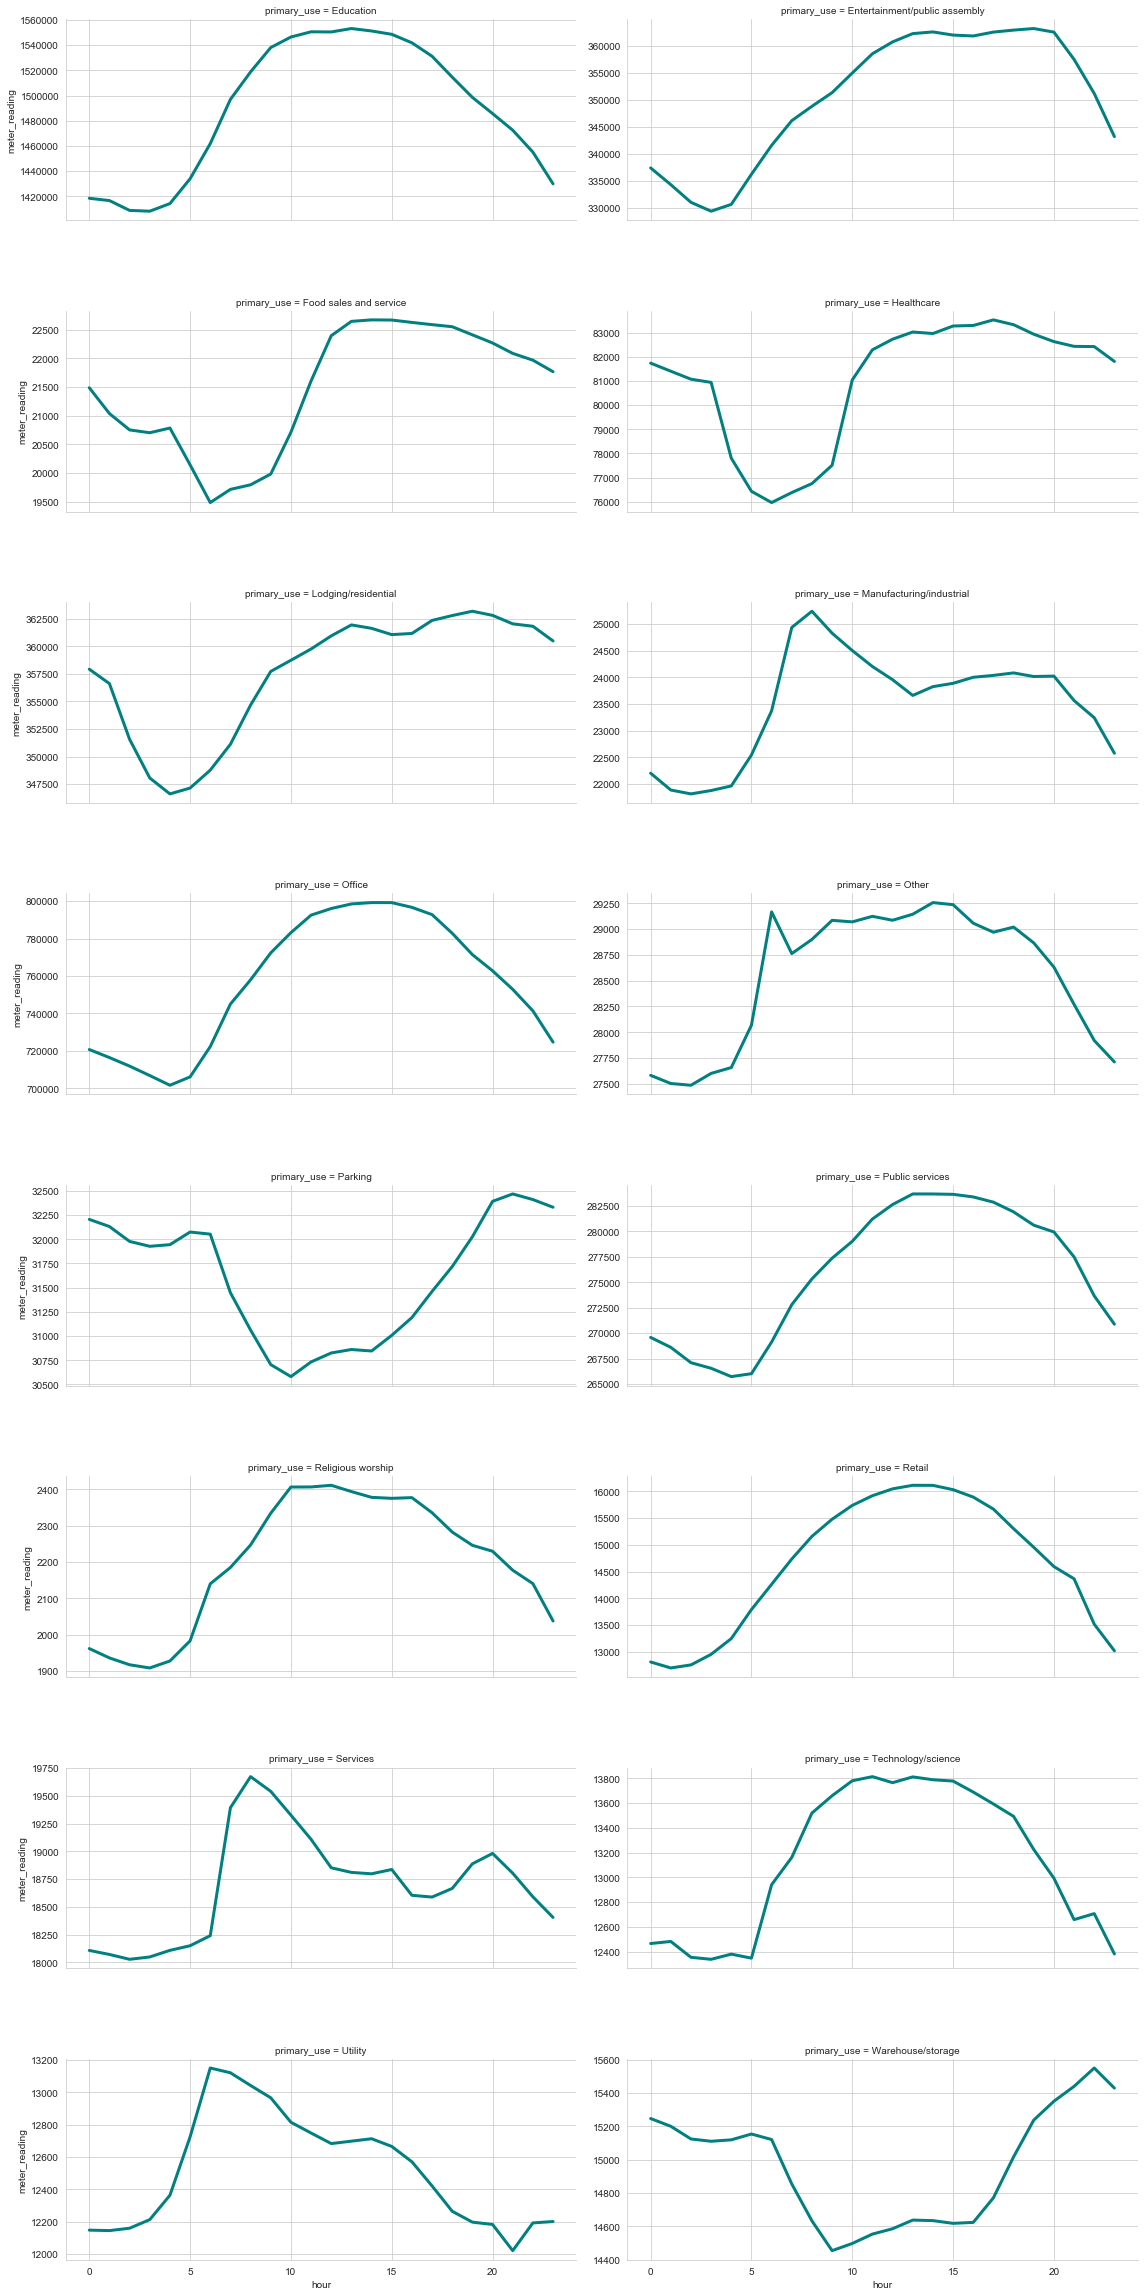

In [43]:
# bold('**MONTHLY READINGS ARE HIGHEST CHANGES BASED ON BUILDING TYPE**')
temp_df = train.groupby(['hour', 'primary_use']).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(plt.plot, 'hour', 'meter_reading', color="teal", linewidth = 3)
plt.subplots_adjust(hspace=0.45)
plt.show()

There are considerable differences between building types as to when meter readings are highest. Almost all the building peak in the end of the year due to winter season.

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

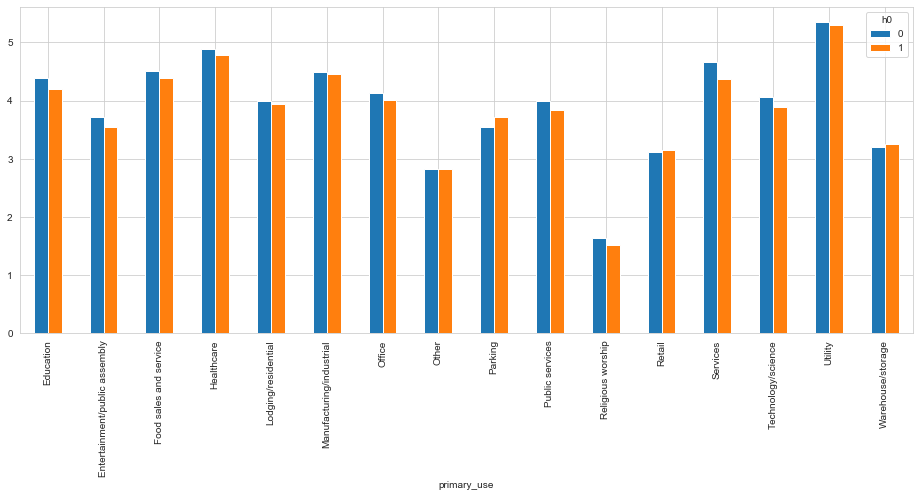

In [56]:
train.groupby(['h0', 'primary_use']).meter_reading.mean().reset_index().pivot_table(
    index='primary_use', columns='h0', values='meter_reading').plot(kind='bar')

**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**

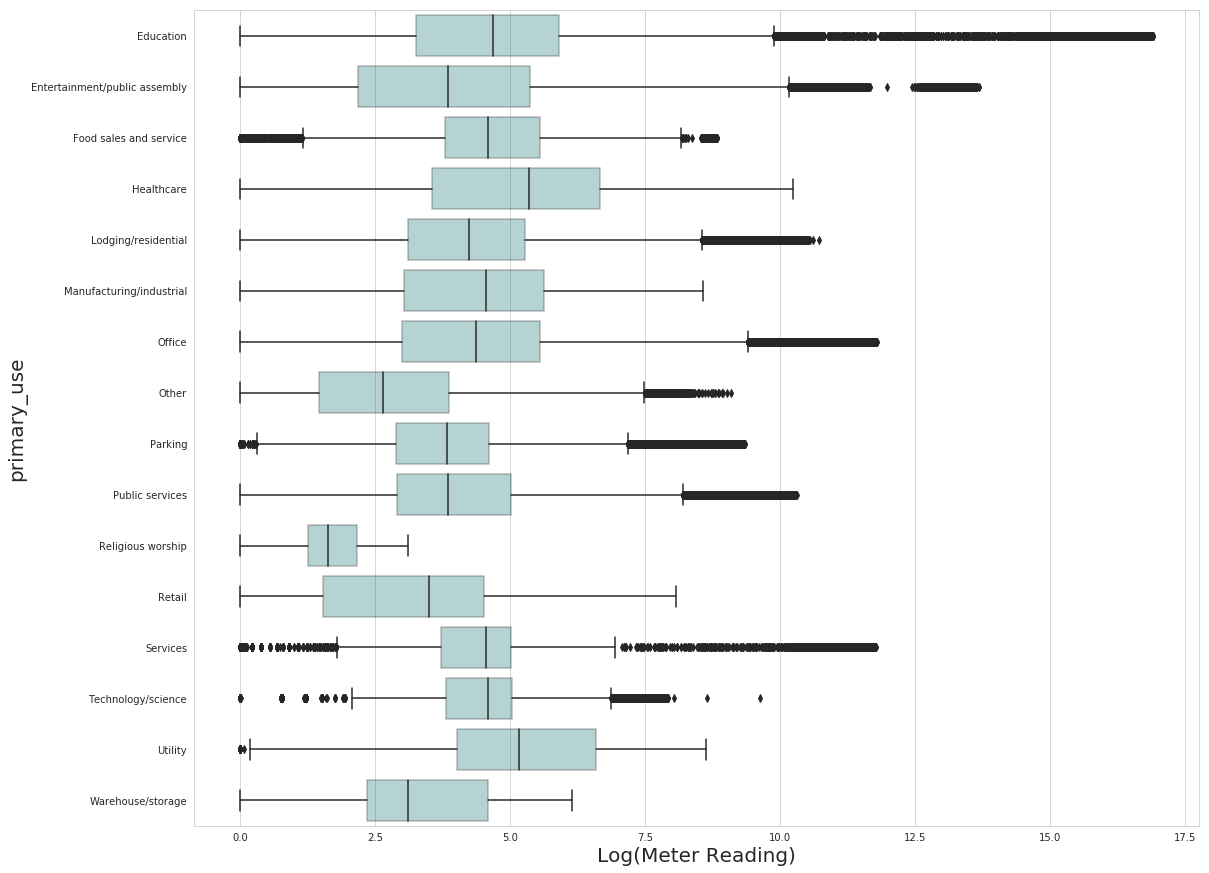

In [22]:
bold('**UTILITIES AND HEALTHCARE HAVE THE HIGHEST READINGS**')
plt.rcParams['figure.figsize'] = (18, 15)
ax = sns.boxplot(data = train, y ='primary_use', x = 'meter_reading', color = 'teal', boxprops=dict(alpha=.3))
ax.set_xlabel('Log(Meter Reading)', fontsize = 20)
ax.set_ylabel('primary_use', fontsize = 20)
plt.show()

We can see that Utility and Healthcare places tend to have the highest readings, while Religious Worship places the least - they’re no doubt frequented less often than the higher energy users.

**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:715: UserWarning:

Using the boxplot function without specifying `order` is likely to produce an incorrect plot.



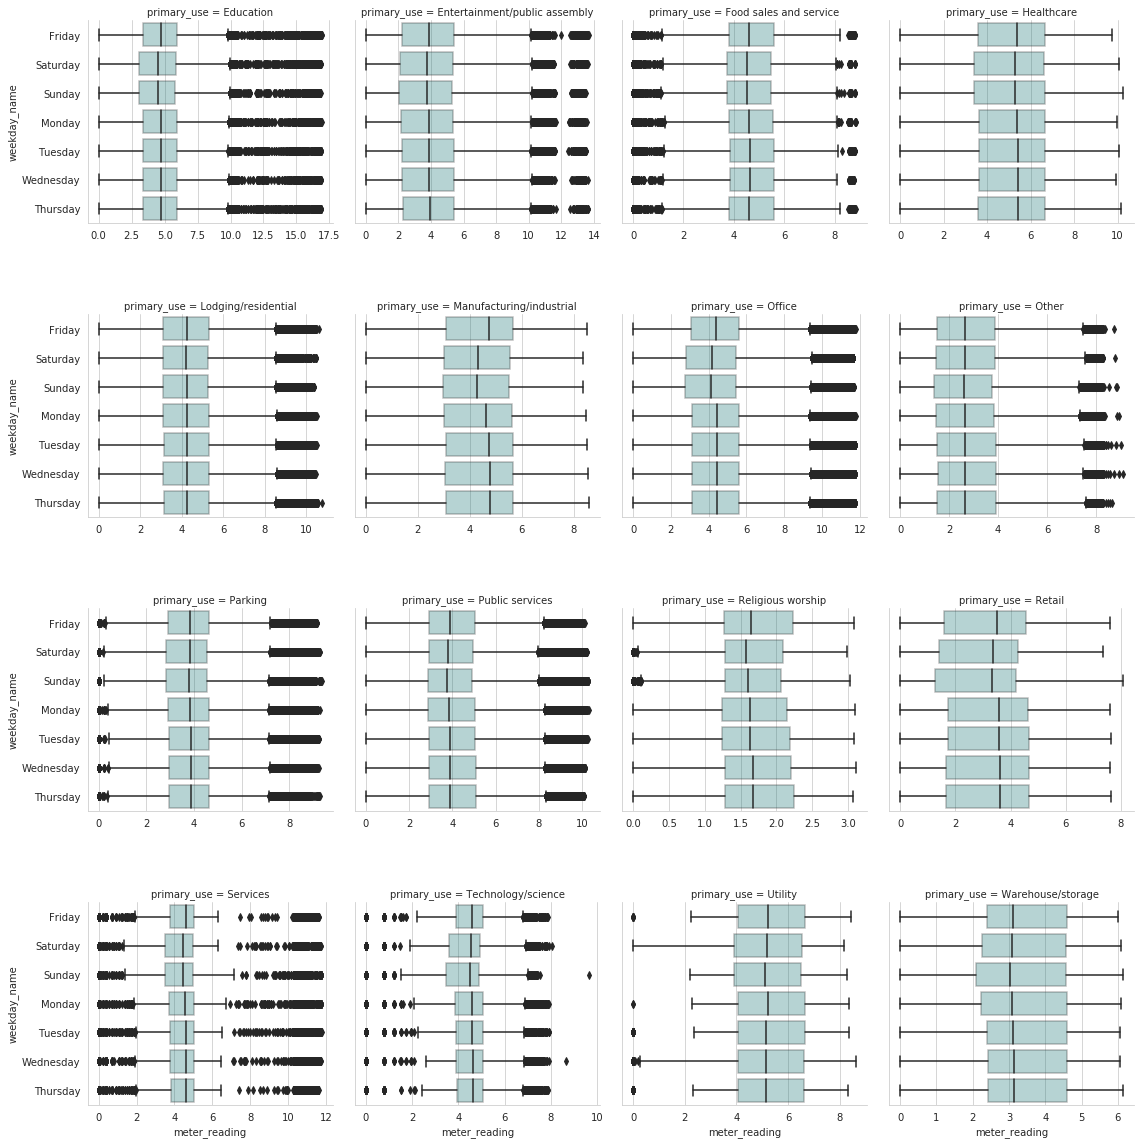

In [23]:
bold('**PLACES OF INDUSTRY HIGHEST READINGS ON WEEKDAYS**')
ax = sns.FacetGrid(train, col="primary_use", col_wrap=4, height=4, aspect=1,  sharex=False)
ax.map(sns.boxplot, 'meter_reading', 'weekday_name', color="teal",   boxprops=dict(alpha=.3))
plt.subplots_adjust(hspace=0.45)
plt.show()

Healthcare, Education, Manufacturing/ Industrial, Techonology/science, Utilities building has highest reading on weekdays compares to the others.

Religious worship places have higher readings on weekends.



## 3.6 Meter Readings over time

**READINGS REALLY PEAKED FROM MAY TO OCTOBER**

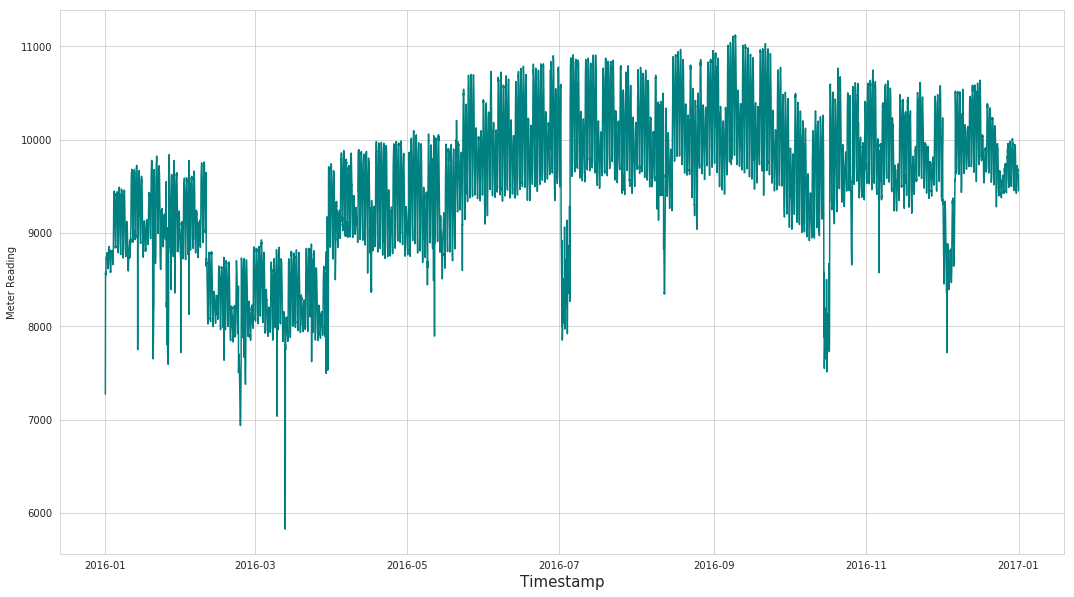

In [24]:
bold('**READINGS REALLY PEAKED FROM MAY TO OCTOBER**')
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby(['timestamp', 'month']).meter_reading.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'timestamp', y = 'meter_reading', color = 'teal')
plt.xlabel('Timestamp', fontsize = 15)
plt.ylabel('Meter Reading')
plt.show()

Interestingly, the meter reading per reading began rising in May and peaked between July and October 2016.

### Meter Readings over time And Primary Use

**MANUFACTURING REALLY BUCKED THE GENERAL TREND**

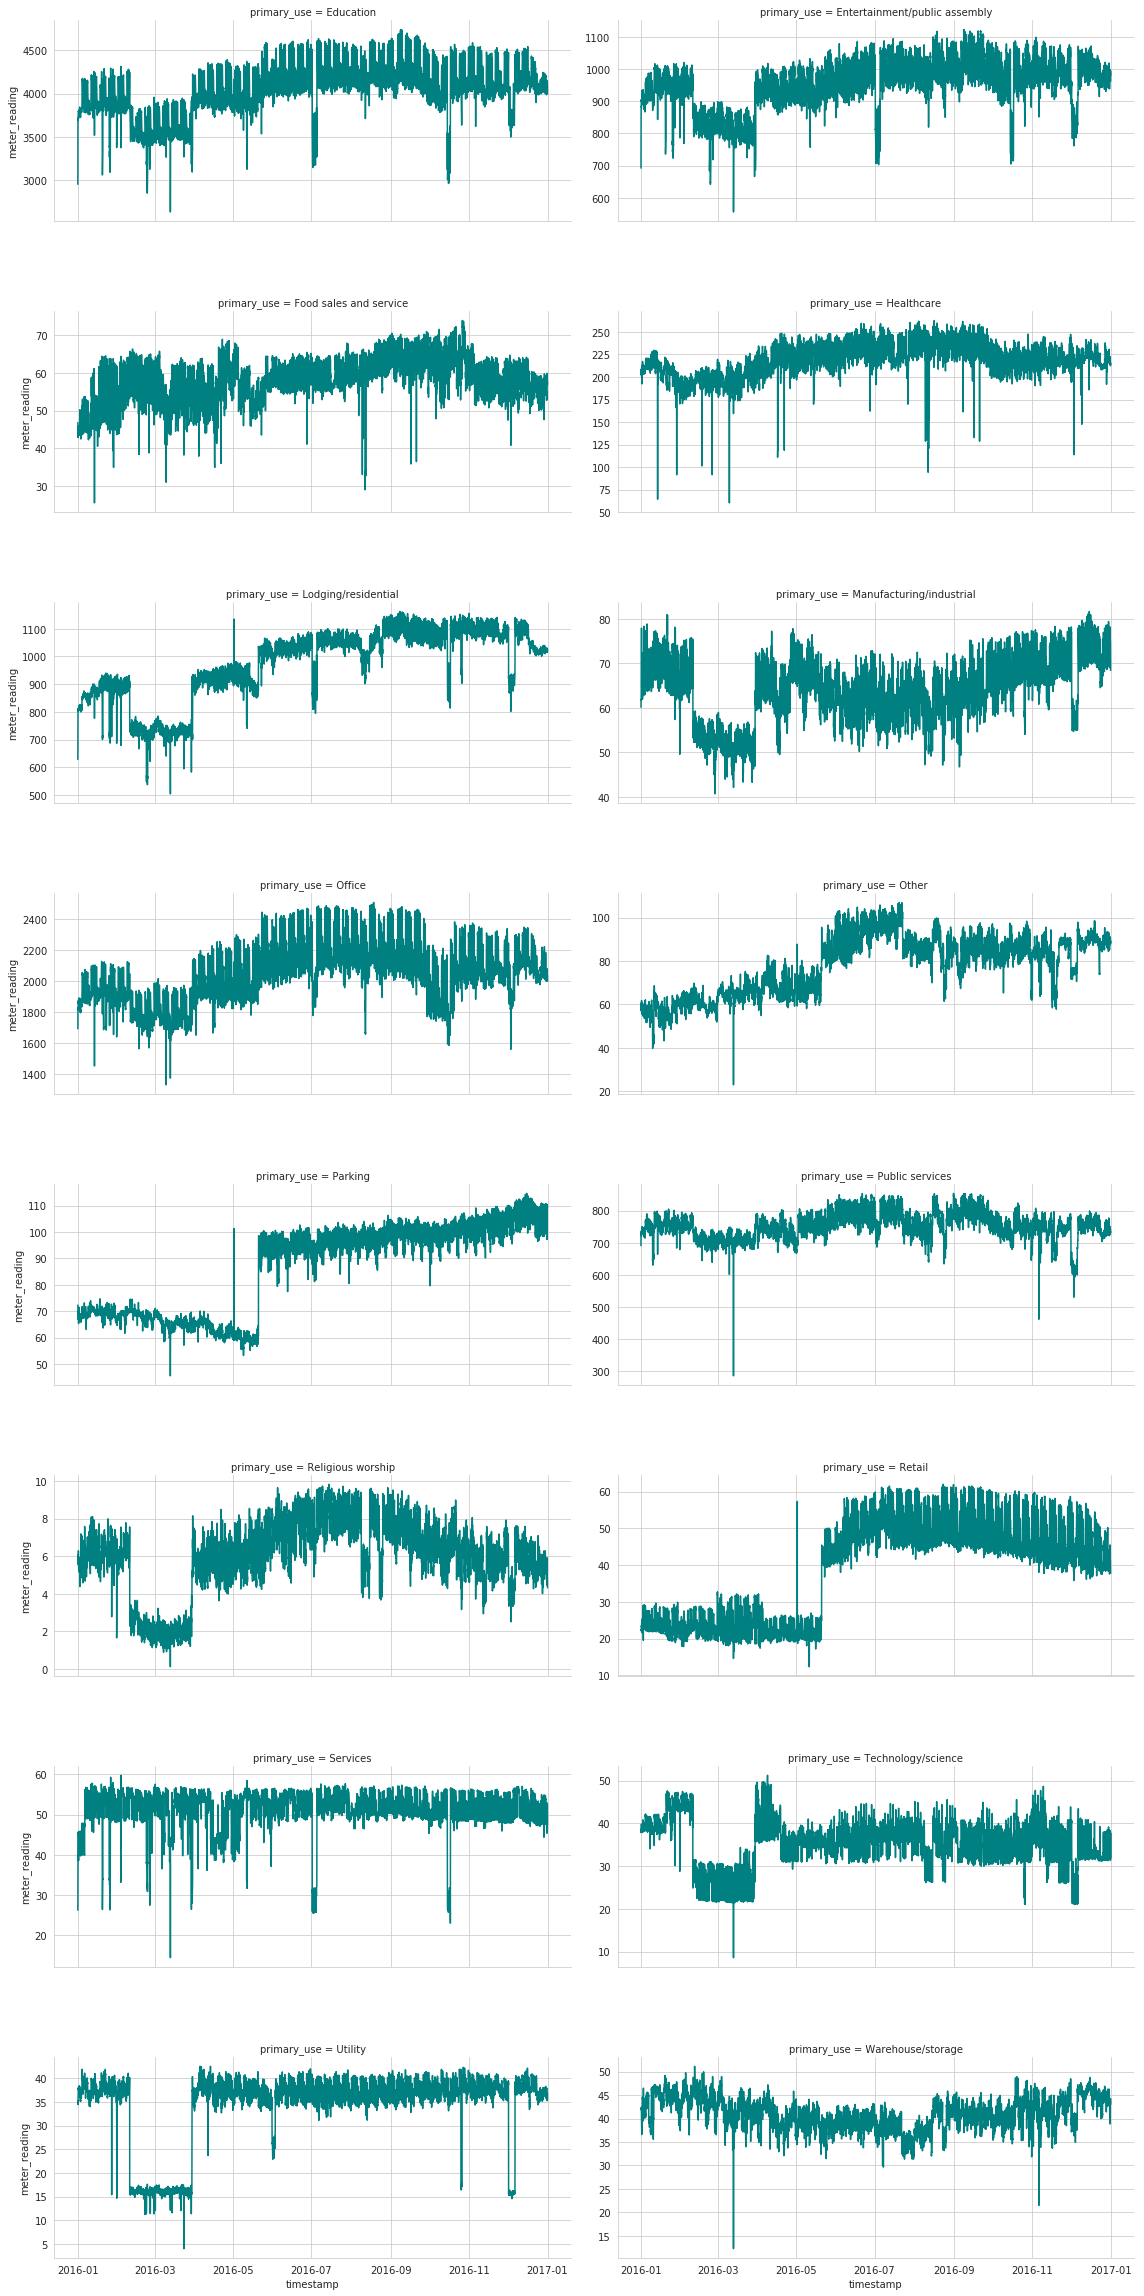

In [25]:
bold('**MANUFACTURING REALLY BUCKED THE GENERAL TREND**')
temp_df = train.groupby(['timestamp', "primary_use"]).meter_reading.sum().reset_index()
ax = sns.FacetGrid(temp_df, col="primary_use", col_wrap=2, height=4, aspect=2,  sharey=False)
ax.map(sns.lineplot,'timestamp',  'meter_reading', color="teal")
plt.subplots_adjust(hspace=0.45)
plt.show()

The trend holds for most of the different building types, with a few notable exceptions; Manufacturing dips during that peak period outlined above, while Services, Technology, Utility and Warehouse remained fairly constant over the year.

In [101]:
meta.describe()

,site_id,building_id,square_feet,year_built,floor_count
count,1449.000000,1449.000000,1449.000000,675.0000,355.000000
mean,6.952381,724.000000,92111.776398,inf,3.740234
std,5.003432,418.434583,110769.950997,31.0625,3.333984
min,0.000000,0.000000,283.000000,1900.0000,1.000000
25%,3.000000,362.000000,23012.000000,1949.0000,1.000000
50%,5.000000,724.000000,57673.000000,1970.0000,3.000000
75%,13.000000,1086.000000,115676.000000,1995.0000,5.000000
max,15.000000,1448.000000,875000.000000,2017.0000,26.000000


In [109]:
meter_corr

,Electricity,HotWater,ChilledWater,Steam
site_id,0.134981,0.375611,-0.169305,0.297573
square_feet,0.629480,0.175471,0.271611,0.234951
year_built,0.073019,0.098325,0.351452,-0.011849
floor_count,0.500677,0.097977,0.249861,-0.244710
air_temperature,0.010384,-0.416473,0.465907,-0.405818
cloud_coverage,-0.031336,-0.130315,-0.015256,0.115124
dew_temperature,-0.040549,-0.218369,0.424500,-0.390635
precip_depth_1_hr,-0.001092,0.030422,0.009198,-0.006983
sea_level_pressure,-0.043619,0.180848,-0.104425,0.064586
wind_direction,-0.013899,0.047330,-0.057533,0.110102


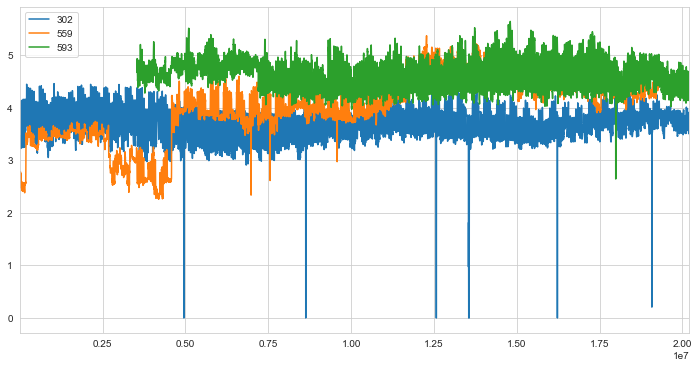

In [116]:
plt.figure(figsize=(12, 6))
for b in meta[meta.year_built == 2015].building_id:
    train[(train.building_id == b) & (train.meter == 'Electricity')].meter_reading.plot(label=b)
plt.legend()

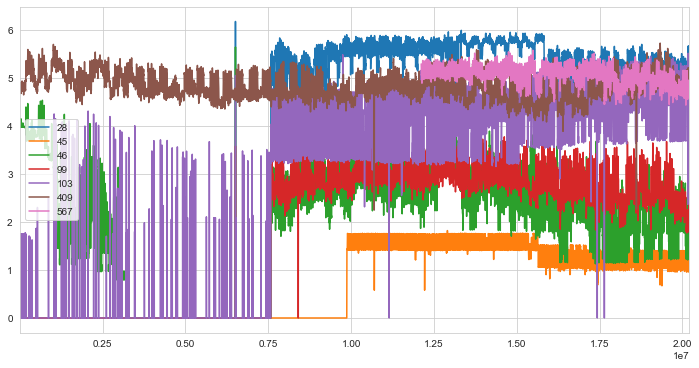

In [117]:
plt.figure(figsize=(12, 6))
for b in meta[meta.year_built == 2016].building_id:
    train[(train.building_id == b) & (train.meter == 'Electricity')].meter_reading.plot(label=b)
plt.legend()

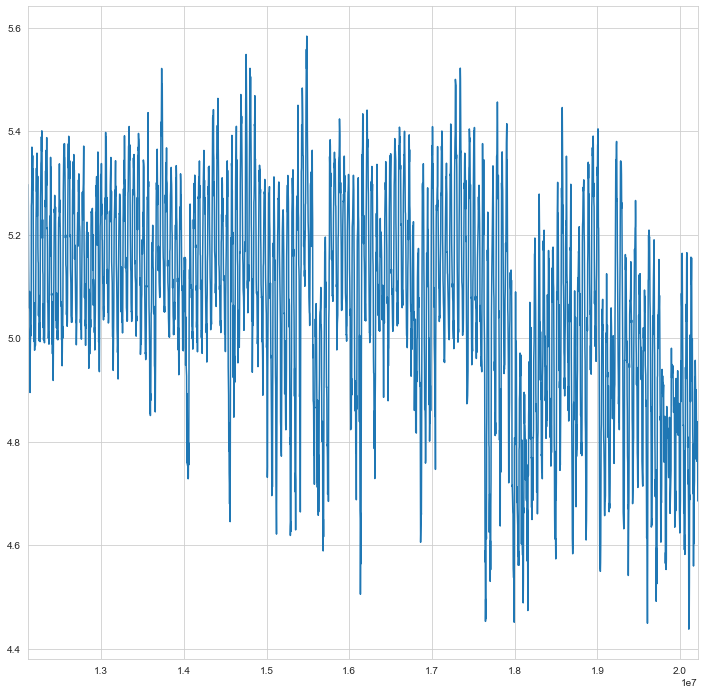

In [145]:
train[(train.meter == 'Electricity') & (train.building_id ==567)].meter_reading.plot()

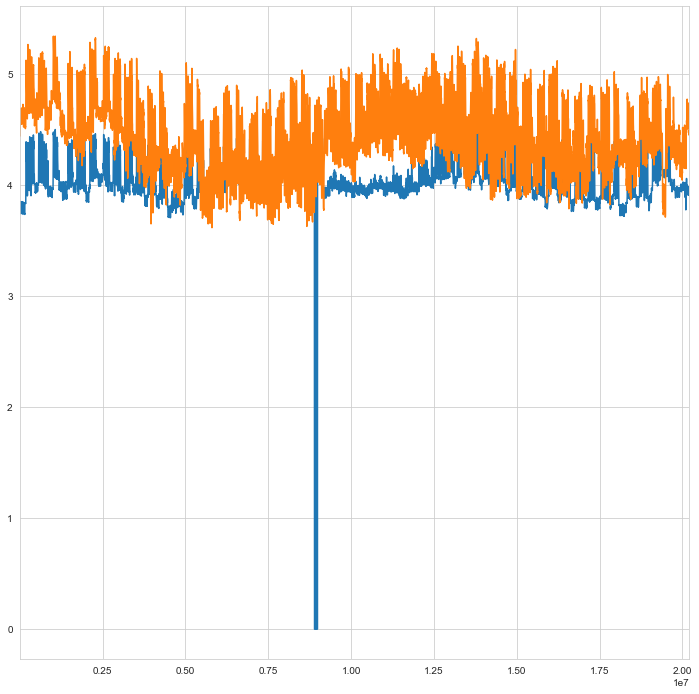

In [143]:
# train[(train.meter == 'Electricity') & (train.building_id ==488)].meter_reading.plot()
# train[(train.meter == 'Electricity') & (train.building_id ==417)].meter_reading.plot()
# train[(train.meter == 'Electricity') & (train.building_id ==886)].meter_reading.plot()
train[(train.meter == 'Electricity') & (train.building_id ==360)].meter_reading.plot()
train[(train.meter == 'Electricity') & (train.building_id ==461)].meter_reading.plot()

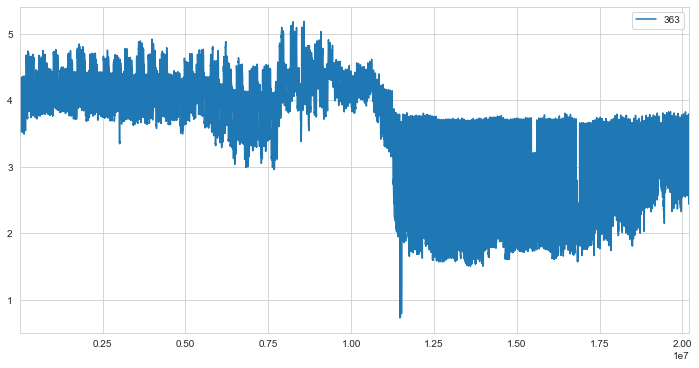

In [137]:
plt.figure(figsize=(12, 6))
for b in meta[meta.year_built == 2017].building_id:
    train[(train.building_id == b) & (train.meter == 'Electricity')].meter_reading.plot(label=b)
plt.legend()

In [125]:
meta[meta.building_id == 363]

,site_id,building_id,primary_use,square_feet,year_built,floor_count
363,3,363,Education,69300,2017.0,NaN


In [135]:
meta[(meta.primary_use == 'Education') & (meta.square_feet < 70000)].sort_values('square_feet')

,site_id,building_id,primary_use,square_feet,year_built,floor_count
566,4,566,Education,2010,1957.0,1.0
1,0,1,Education,2720,2004.0,NaN
22,0,22,Education,3569,1996.0,NaN
634,4,634,Education,4000,1910.0,4.0
637,4,637,Education,4189,1929.0,3.0
...,...,...,...,...,...,...
461,3,461,Education,69400,1959.0,NaN
360,3,360,Education,69600,1949.0,NaN
417,3,417,Education,69600,1978.0,NaN
488,3,488,Education,69600,1908.0,NaN


In [123]:
meta.year_built.sort_values(ascending=False)

363     2017.0
567     2016.0
28      2016.0
409     2016.0
45      2016.0
         ...  
1357       NaN
1370       NaN
1395       NaN
1421       NaN
1445       NaN
Name: year_built, Length: 1449, dtype: float16

## 3.7 Correlation between meter_reading And Numeric Variable

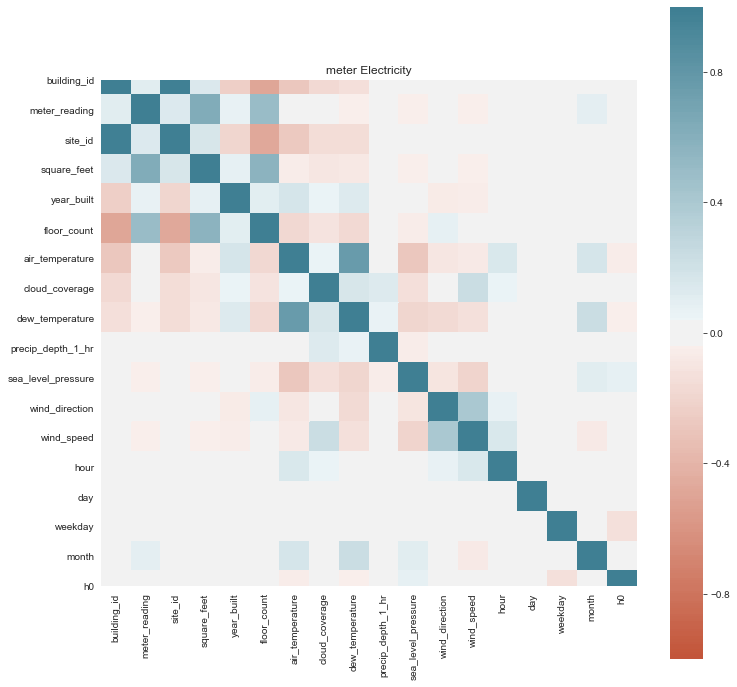

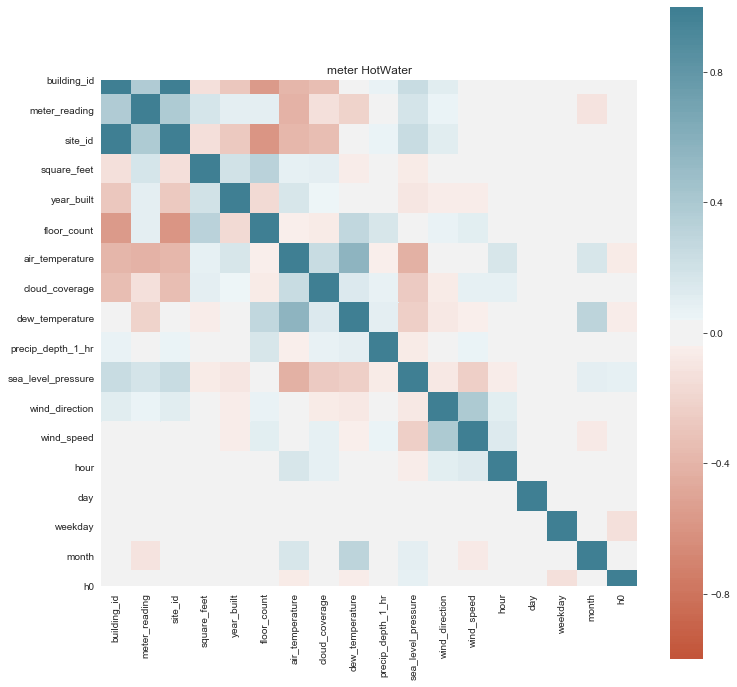

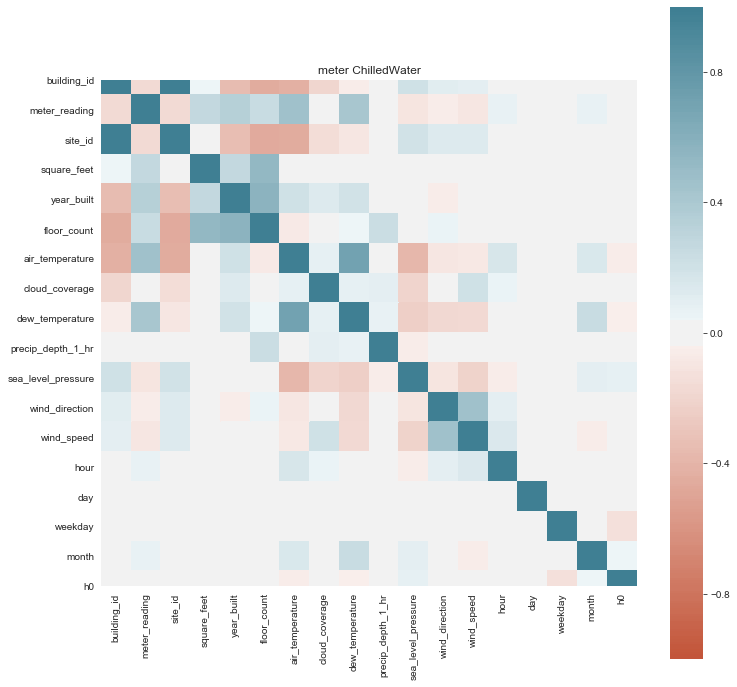

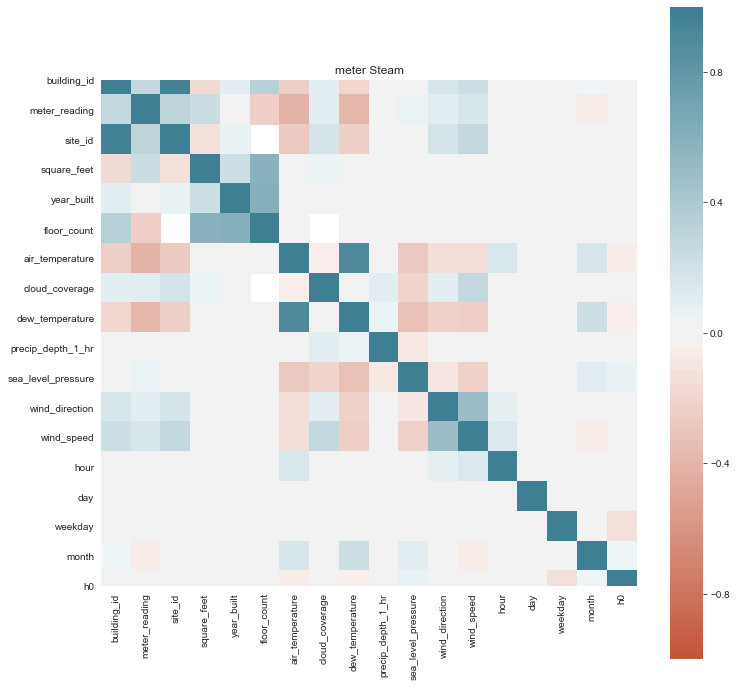

In [74]:
meter_corr = pd.DataFrame()
for meter in train.meter.unique():
    plt.figure()
    plt.rcParams['figure.figsize'] = (12,12)
    tmp = train[train.meter == meter].corr()
    sns.heatmap(tmp, vmin=-1, vmax=1, center=0,
                square=True, cmap = sns.diverging_palette(20, 220, n=200))
    plt.title(f'meter {meter}')
    meter_corr[meter] = tmp['meter_reading'].iloc[2:]

In [80]:
meter_corr

,Electricity,HotWater,ChilledWater,Steam
site_id,0.134981,0.375611,-0.169305,0.297573
square_feet,0.629480,0.175471,0.271611,0.234951
year_built,0.073019,0.098325,0.351452,-0.011849
floor_count,0.500677,0.097977,0.249861,-0.244710
air_temperature,0.010384,-0.416473,0.465907,-0.405818
cloud_coverage,-0.031336,-0.130315,-0.015256,0.115124
dew_temperature,-0.040549,-0.218369,0.424500,-0.390635
precip_depth_1_hr,-0.001092,0.030422,0.009198,-0.006983
sea_level_pressure,-0.043619,0.180848,-0.104425,0.064586
wind_direction,-0.013899,0.047330,-0.057533,0.110102


In [92]:
cond = train.building_id == 1
train[cond].groupby(train[cond].timestamp.dt.date)['meter_reading'].mean() / train[cond].meter_reading.mean()
train[cond].groupby(train[cond].timestamp.dt.date)['air_temperature'].mean() / train[cond].air_temperature.mean()

timestamp
2016-01-01    0.0
2016-01-02    0.0
2016-01-03    0.0
2016-01-04    0.0
2016-01-05    0.0
             ... 
2016-12-27    0.0
2016-12-28    0.0
2016-12-29    0.0
2016-12-30    0.0
2016-12-31    0.0
Name: air_temperature, Length: 366, dtype: float16

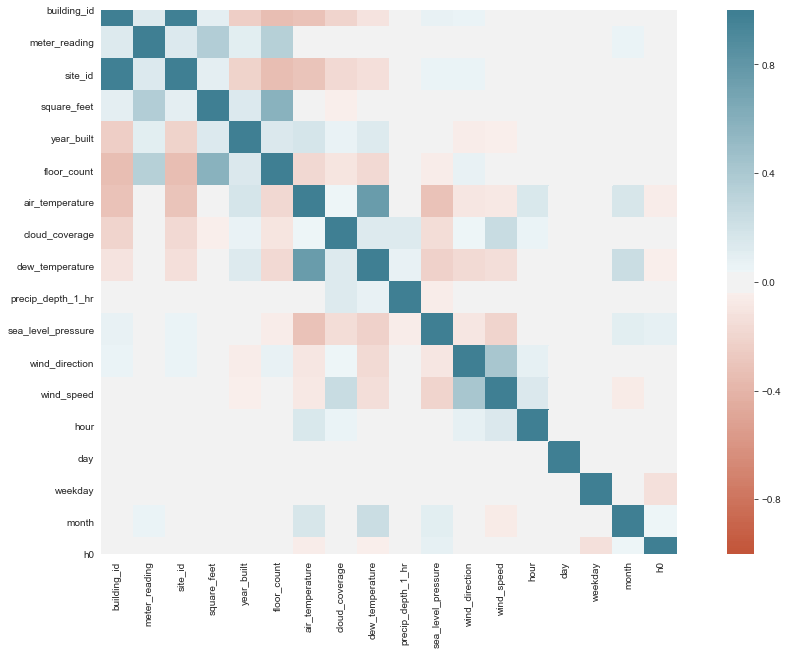

In [58]:
plt.rcParams['figure.figsize'] = (18,10)
all_corr = train.corr()
sns.heatmap(all_corr, vmin=-1, vmax=1, center=0,
            square=True, cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

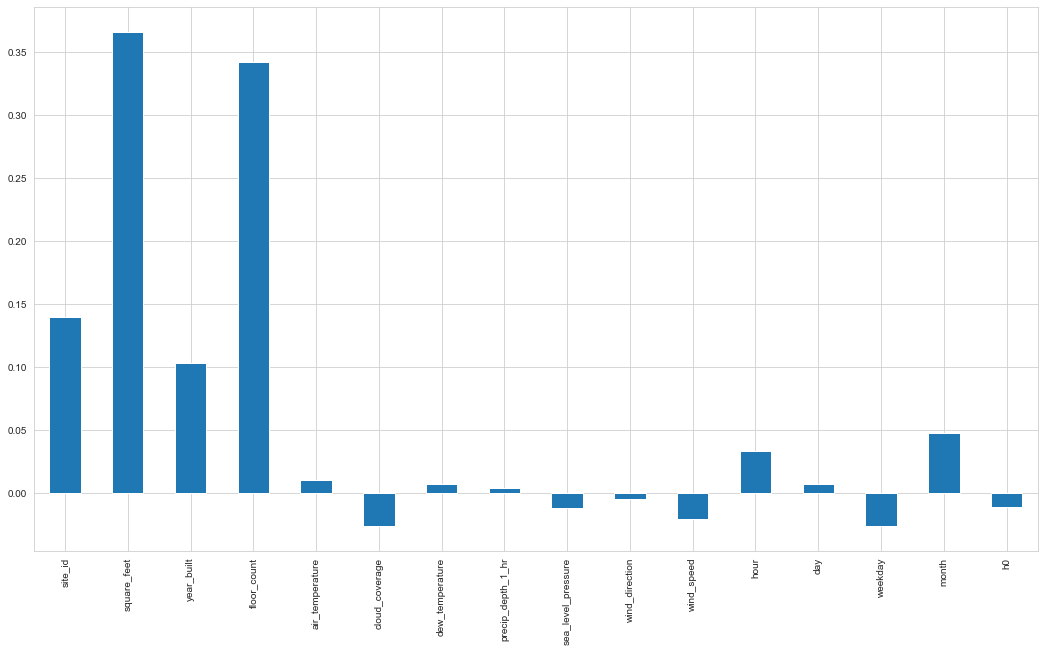

In [63]:
all_corr['meter_reading'].iloc[2:].plot(kind='bar')

Square feet and floor count highly positive correlated ie, the bigger the building, the higher the reading and year building build and meter type moderate positive correlated also.

wind_speed, air_temperature and cloud_coverage may be important in any model that gets built.

## 3.8 Square Feet

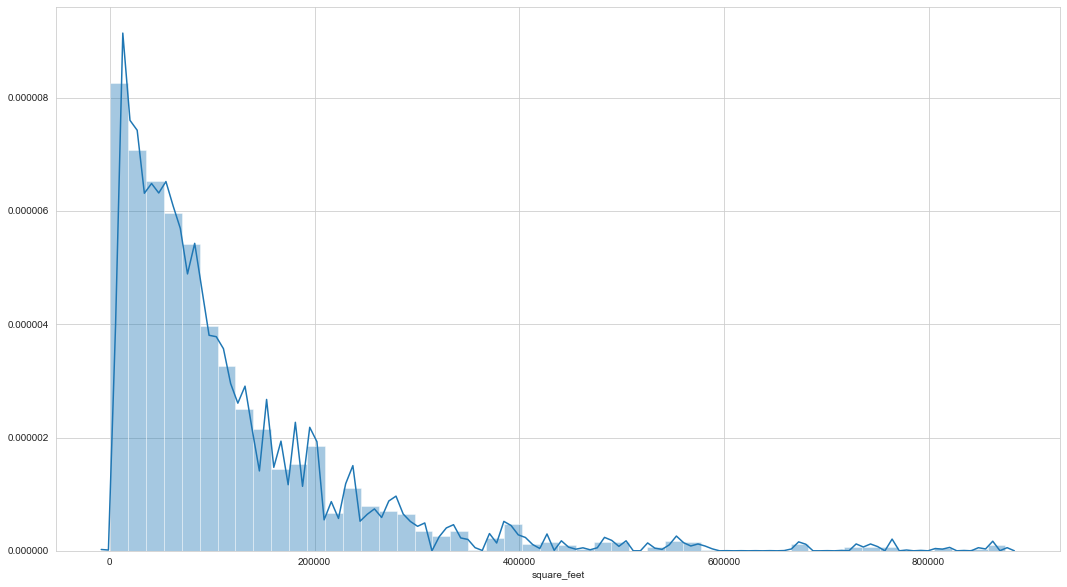

In [65]:
'''Distribution of the Meter Reading'''
sns.distplot(train['square_feet'])

Square feet size is positively Skewed.

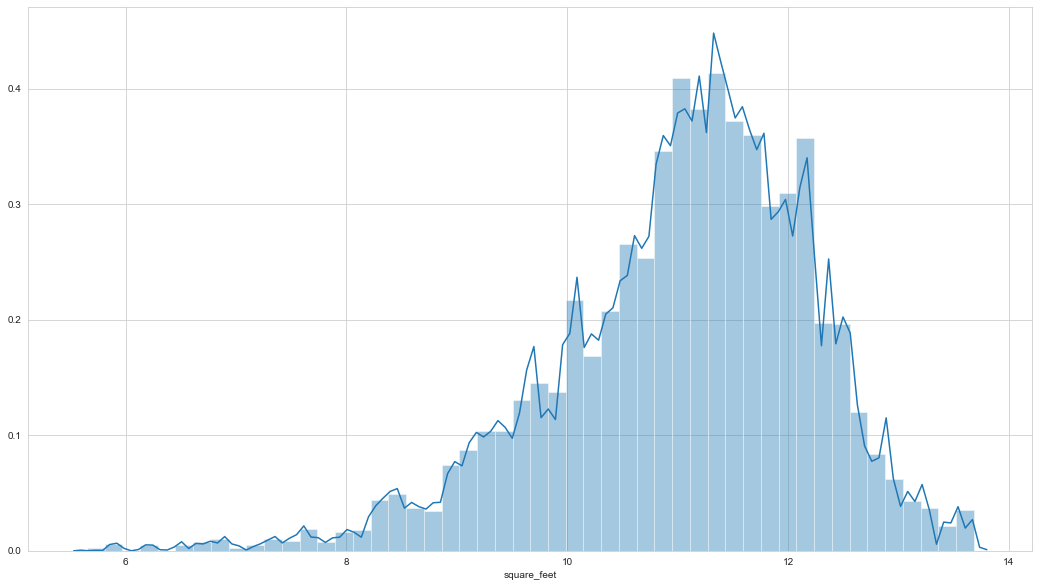

In [66]:
'''Log tranformation of meter_reading'''
train['square_feet'] = np.log1p(train['square_feet'])
test['square_feet'] = np.log1p(test['square_feet'])

sns.distplot(train['square_feet'])

## 3.9 Year Built

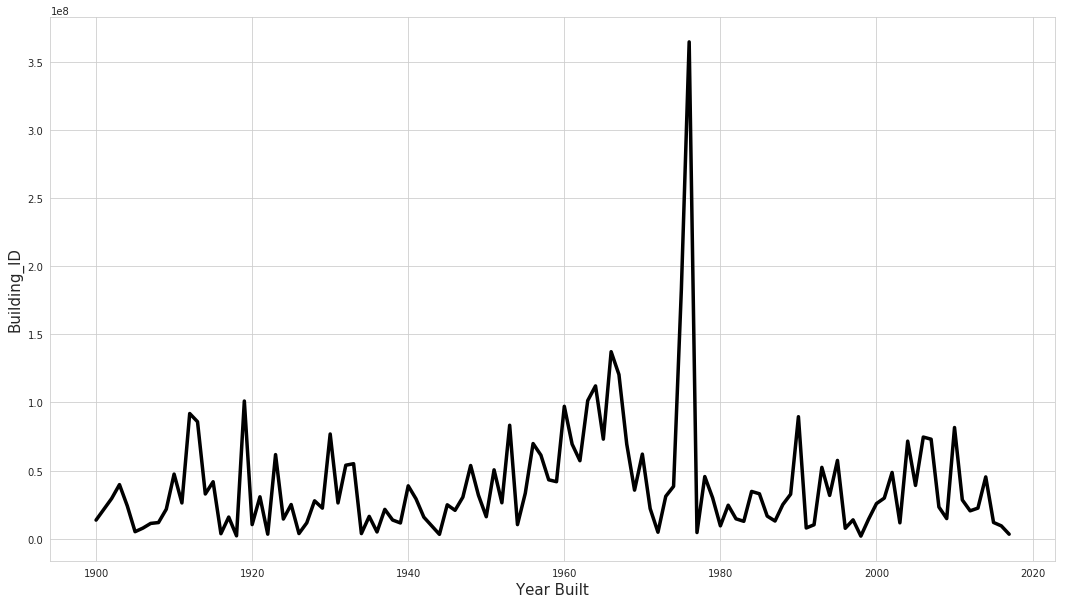

In [29]:
plt.rcParams['figure.figsize'] = (18,10)
temp_df = train.groupby('year_built').building_id.sum().reset_index()
ax = sns.lineplot(data = temp_df, x = 'year_built', y = 'building_id', color = 'black', linewidth = 3.5)
plt.xlabel('Year Built', fontsize = 15)
plt.ylabel('Building_ID', fontsize = 15)
plt.show()

## 3.10 Floor Count

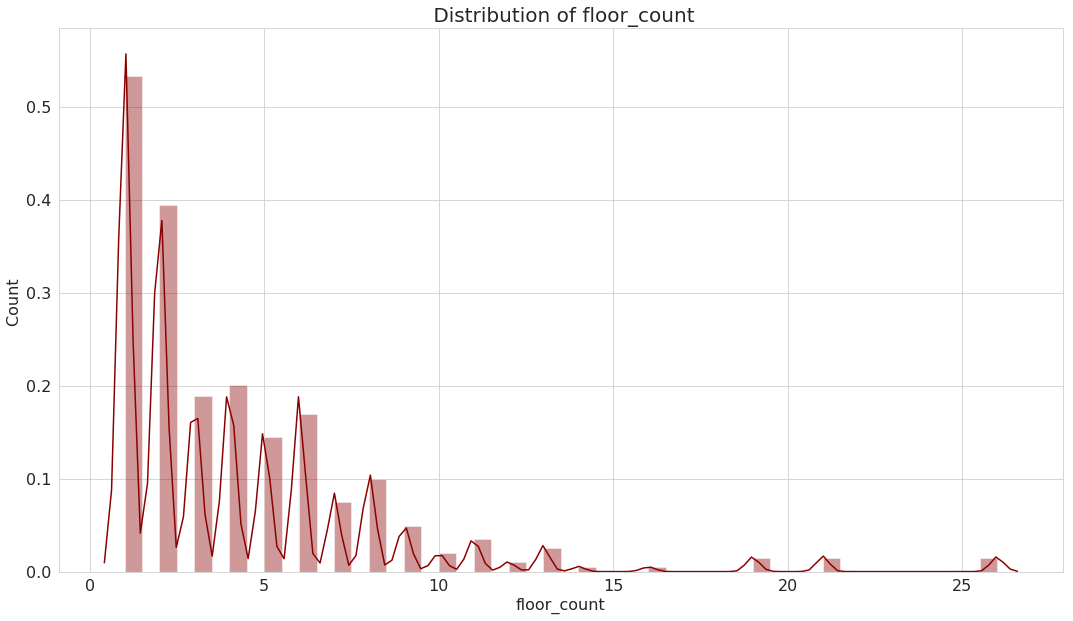

In [30]:
'''Distribution of the Meter Reading'''
distplot(train['floor_count'].dropna(), 'darkred')

There are 16,709,167 missing records in the floor_count variable. Of the 1449 unique building IDs, 1094 don’t have a floor count.

Of those that do, we can see that there aren’t too many buildings with more than 10 floors, while the median number of floors is 3.

## 3.11 Air Temperature

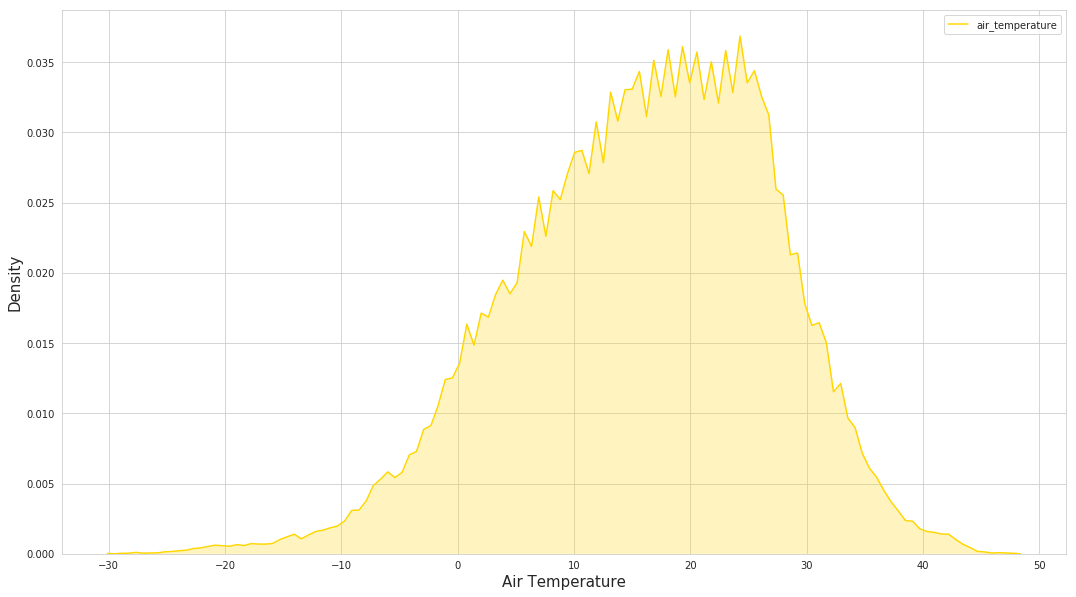

In [31]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['air_temperature'].dropna(), shade = True, color = 'gold')
plt.xlabel('Air Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~10 and 25 degrees.

## 3.12 Dew Temperature

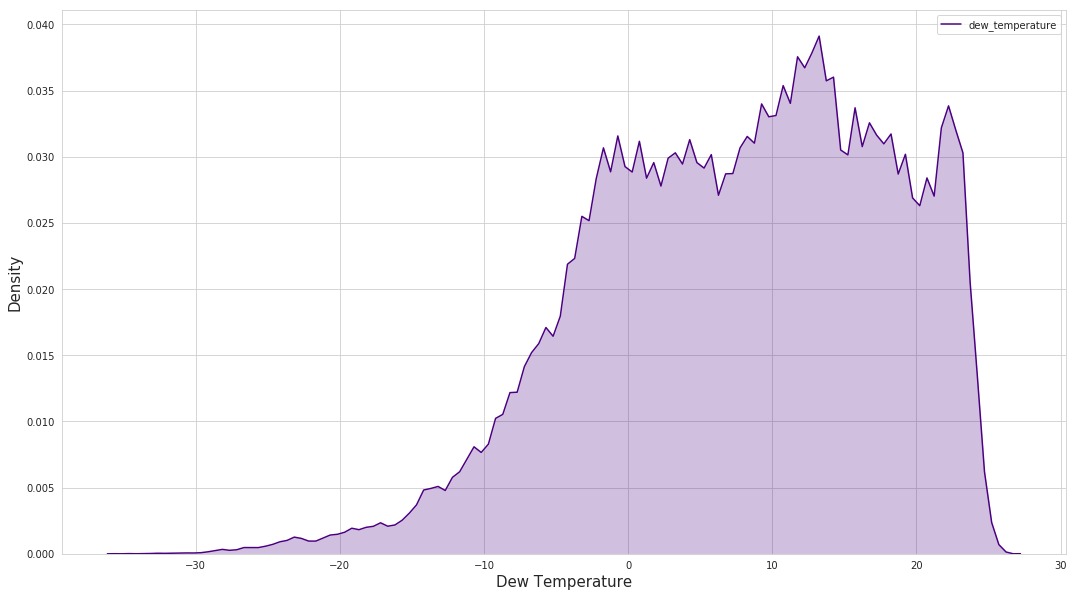

In [32]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['dew_temperature'].dropna(), shade = True, color = 'indigo')
plt.xlabel('Dew Temperature', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between ~13 and 25 degrees.

## 3.13 Wind Speed

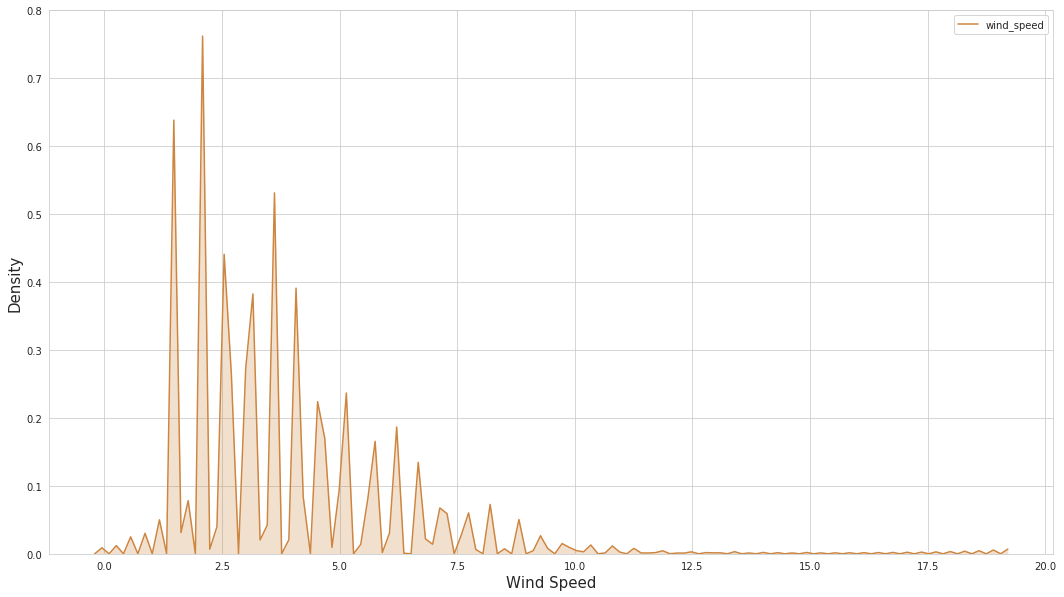

In [33]:
plt.rcParams['figure.figsize'] = (18,10)
sns.kdeplot(train['wind_speed'].dropna(), shade = True, color = 'peru')
plt.xlabel('Wind Speed', fontsize = 15)
plt.ylabel('Density', fontsize = 15)
plt.show()

Plotting the variable shows the variable to be fairly normally distributed, with the majority of recordings being between 1.5 and 3.5 Meters per second

## 3.14 Wind direction & Wind speed
In heatmap plot wind direction and wind speed are highly correlated. So, it is good to plot together.

wind_direction - Compass direction (0-360)

wind_speed - Meters per second

Ok, plotting this is tricky, so I am going to do it using [this manual](https://gist.github.com/phobson/41b41bdd157a2bcf6e14)

Code source: https://www.kaggle.com/nroman/eda-for-ashrae

First of all: direction of 0° and 360° is the same thing. But both are presented in the datasets.

In [34]:
def speed_labels(bins:list, units:str) -> list:   
    labels = list()
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif np.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))
    return labels

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * np.pi/180. - np.pi/N
    barWidth = 2 * np.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 5, 10, 15, 20, 25, 30, np.inf]
spd_labels = speed_labels(spd_bins, units='m/s')

dir_bins = np.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

In [35]:
calm_count = train[train['wind_speed'] == 0].shape[0]
total_count = len(train)
rose = (train.assign(WindSpd_bins=lambda df:
            pd.cut(df['wind_speed'], bins=spd_bins, labels=spd_labels, right=True)).assign(WindDir_bins=lambda df: pd.cut(df['wind_direction'], bins=dir_bins, labels=dir_labels, right=False)).replace({'WindDir_bins': {360: 0}}).groupby(by=['WindSpd_bins', 'WindDir_bins']).size().unstack(level='WindSpd_bins').fillna(0).assign(calm=lambda df: calm_count / df.shape[0]).sort_index(axis=1).applymap(lambda x: x / total_count * 100))
rose.drop(rose.index[0], inplace=True)
directions = np.arange(0, 360, 15)

In [36]:
def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = sns.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)
            # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig


This is a wind rose for TRAIN:

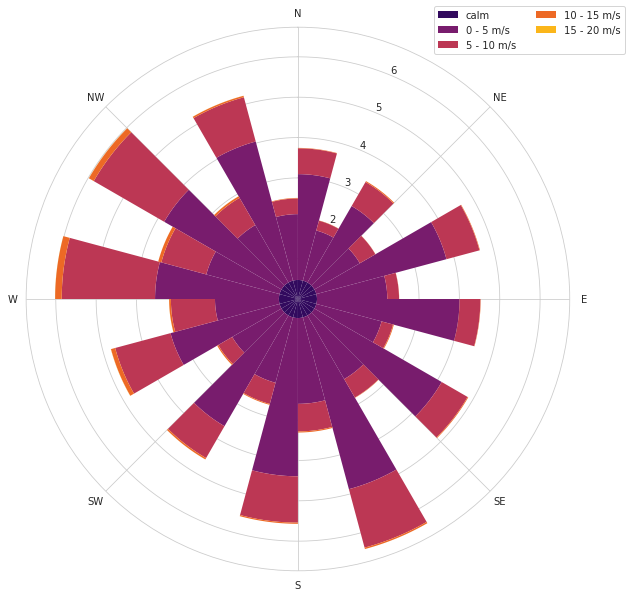

In [37]:
fig = wind_rose(rose, directions)

# 4. Feature Engineering - Part II

## 4.1 Imputing Missing variable

In [38]:
'''Imputing missing value of year build'''
train['year_built'] = np.uint8(train['year_built']-1900, inplace = True)
test['year_built'] = np.uint8(test['year_built']-1900, inplace = True)

In [39]:
'''The following variables are either discrete numerical or continuous numerical variables.So the will be imputed by median'''
to_impute_by_median = train.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    train[i].fillna(train[i].median(), inplace = True)

to_impute_by_median = test.loc[:, ['floor_count','air_temperature', 'cloud_coverage', 'dew_temperature',
                      'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction','wind_speed']]
for i in to_impute_by_median.columns:
    test[i].fillna(test[i].median(), inplace = True)

## 4.2 Encoding Categorical Variable

In [40]:
'''Using sklearn's label encoder method'''
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train['primary_use'] = le.fit_transform(train['primary_use'])
test['primary_use'] = le.fit_transform(test['primary_use'])

In [41]:
'''Now extract the nominal variables for one hot encoding of train and test data.'''
one_hot_train = pd.get_dummies(train['meter'])

one_hot_test = pd.get_dummies(test['meter'])

In [42]:
'''Droping variable'''
train.drop(columns=['meter', 'timestamp', 'weekday_name'], axis = 1, inplace = True)
test.drop(columns=['meter', 'timestamp'], axis = 1, inplace = True)

In [43]:
"""Let's concate one hot encoded, other variables together."""
train_processed = pd.concat([one_hot_train, train], axis = 1)
test_processed = pd.concat([one_hot_test, test], axis = 1)

# Baseline

In [44]:
"""Let's look at our final train and test data for modelling."""
bold('**Updated train data for modelling:**')
display(train_processed.head(3))
bold('**Updated test data for modelling:**')
display(test_processed.head(3))

**Updated train data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,building_id,meter_reading,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,0,1,0,0,0,0.0,0,0,8.913685,108,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
1,0,1,0,0,1,0.0,0,0,7.908755,104,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1
2,0,1,0,0,2,0.0,0,0,8.589886,91,...,6.0,20.0,0.0,1019.5,0.0,0.0,0,1,4,1


**Updated test data for modelling:**

,ChilledWater,Electricity,HotWater,Steam,row_id,building_id,site_id,primary_use,square_feet,year_built,...,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,hour,day,weekday,month
0,0,1,0,0,0,0,0,0,8.913685,108,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1
1,0,1,0,0,1,1,0,0,7.908755,104,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1
2,0,1,0,0,2,2,0,0,8.589886,91,...,4.0,11.703125,0.0,1021.5,100.0,3.599609,0,1,6,1


In [45]:
'''Setting train, test and target for model'''
target = train_processed['meter_reading']
train = train_processed.drop(['meter_reading'], axis = 1)
test = test_processed.drop(['row_id'], axis = 1)

In [46]:
"""Let's have a final look at our data"""
bold('**Data Dimension for Model Building:**')
print('Input matrix dimension:', train.shape)
print('Output vector dimension:',target.shape)
print('Test data dimension:', test.shape)

**Data Dimension for Model Building:**

Input matrix dimension: (20216100, 21)
Output vector dimension: (20216100,)
Test data dimension: (41697600, 21)


In [47]:
cat_feat = ['ChilledWater', 'Electricity', 'HotWater', 'Steam',"site_id", "building_id", "primary_use", "hour", "weekday", "wind_direction"]